<a href="https://colab.research.google.com/github/SyrineHammami/Rock-paper-Scissor-Classification/blob/main/my_paper_scissor_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/https-deeplearning-ai/tensorflow-1-public/blob/master/C2/W4/ungraded_lab/C2_W4_Lab_1_multi_class_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ungraded Lab: Multi-class Classifier

In this lab, you will look at how to build a model to distinguish between more than two classes. The code will be similar to the ones you've been using before with a few key changes in the model and in the training parameters. Let's dive in!


**IMPORTANT NOTE:** This notebook is designed to run as a Colab. Running the notebook on your local machine might result in some of the code blocks throwing errors.

## Download and Prepare the Dataset

You will be using the [Rock-Paper-Scissors dataset](http://www.laurencemoroney.com/rock-paper-scissors-dataset/), a gallery of hands images in Rock, Paper, and Scissors poses.

In [ ]:
# rps training set
!pip install --upgrade --no-cache-dir gdown
!gdown --id 1ijWp0qYbA1UQ_6Ivn4wkcRwCl7Ju53PS
  
# rps testing set
!gdown --id 1RaodrRK1K03J_dGiLu8raeUynwmIbUaM

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.3.1-py3-none-any.whl size=14493 sha256=378d458324bafb849f578db3cd2cfae5706c5098bfe37d998f29dd4c11aaeefb
  Stored in directory: /tmp/pip-ephem-wheel-cache-pae9dvns/wheels/39/13/56/88209f07bace2c1af0614ee3326de4a00aad74afb0f4be921d
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.2.1
    Uninstalling gdown-4.2.1:
      Successfully uninstalled gdown-4.2.1
Downloading...
From: https://drive.google.com/uc?id=1ijWp0qYbA1UQ_6Ivn4wkcRwCl7Ju53PS
To: /content/rps.zip
100% 201M/201M [00:02<00:00, 99.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1RaodrRK1K03J_dGiLu8raeUynwmIbUaM
To: /content/rps-test-set.zip
100% 29.5M/29.5M [00:00<00:00, 67.1MB/s]


In [ ]:
import zipfile

# Extract the archive
local_zip = './rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-train')
zip_ref.close()

local_zip = './rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/rps-test')
zip_ref.close()

As usual, you will assign the directory names into variables and look at the filenames as a sanity check.

In [ ]:
import os

base_dir = 'tmp/rps-train/rps'

rock_dir = os.path.join(base_dir, 'rock')
#collects all rock images under one path 
paper_dir = os.path.join(base_dir, 'paper')
scissors_dir = os.path.join(base_dir, 'scissors')

print('total training rock images:', len(os.listdir(rock_dir)))
#we know number of images through the path we just created
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

total training rock images: 840
total training paper images: 840
total training scissors images: 840
['rock02-040.png', 'rock02-108.png', 'rock01-001.png', 'rock07-k03-101.png', 'rock05ck01-082.png', 'rock03-078.png', 'rock03-057.png', 'rock02-006.png', 'rock06ck02-089.png', 'rock06ck02-098.png']
['paper05-083.png', 'paper03-001.png', 'paper03-080.png', 'paper01-023.png', 'paper03-103.png', 'paper02-000.png', 'paper06-035.png', 'paper06-000.png', 'paper03-104.png', 'paper05-069.png']
['scissors04-023.png', 'scissors04-118.png', 'testscissors03-112.png', 'scissors02-114.png', 'scissors03-114.png', 'scissors04-084.png', 'scissors02-001.png', 'scissors01-035.png', 'scissors03-031.png', 'testscissors02-071.png']


You can also inspect some of the images to see the variety in your model inputs.

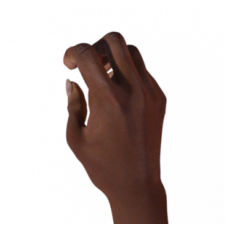

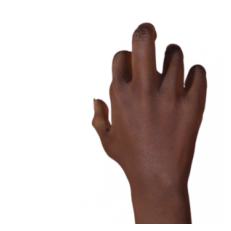

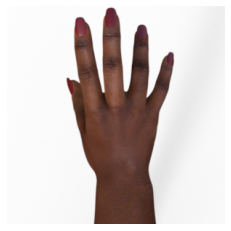

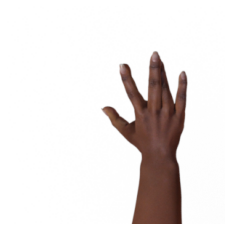

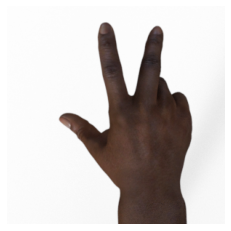

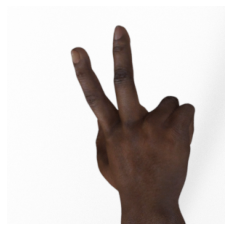

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pic_index = 2

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-2:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-2:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-2:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.axis('Off')
  plt.show()

## Build the model

You will then build your CNN. You will use 4 convolution layers with 64-64-128-128 filters then append a `Dropout` layer to avoid overfitting and some Dense layers for the classification. The output layer would be a 3-neuron dense layer activated by [Softmax](https://www.tensorflow.org/api_docs/python/tf/nn/softmax). You've seen this in Course 1 when you were training with Fashion MNIST. It scales your output to a set of probabilities that add up to 1. The order of this 3-neuron output would be `paper`-`rock`-`scissors` (e.g. a `[0.8 0.2 0.0]` output means the model is prediciting 80% probability for paper and 20% probability for rock.

You can examine the architecture with `model.summary()` below.

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

You will then compile the model. The key change here is the `loss` function. Whereas before you were using `binary_crossentropy` for 2 classes, you will change it to [categorical_crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-function) to extend it to more classes.

In [ ]:
# Set the training parameters
from tensorflow.keras.optimizers import Adam
model.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

## Prepare the ImageDataGenerator

You will prepare the generators as before. You will set the training set up for data augmentation so it can mimick other poses that the model needs to learn.

In [ ]:
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "tmp/rps-train/rps"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
	    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test/rps-test-set"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## Train the model and evaluate the results

You will train for 25 epochs and evaludate the results afterwards. Observe how both the training and validation accuracy are trending upwards. This is a good indication that the model is not overfitting to only your training set.



In [ ]:
# Train the model
history = model.fit(train_generator, epochs=30, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("rps.h5")

Epoch 1/30
20/20 [==============================] - 25s 1s/step - loss: 0.0396 - accuracy: 0.9897 - val_loss: 0.0543 - val_accuracy: 0.9758
Epoch 2/30
20/20 [==============================] - 24s 1s/step - loss: 0.0231 - accuracy: 0.9929 - val_loss: 0.0030 - val_accuracy: 1.0000
Epoch 3/30
20/20 [==============================] - 24s 1s/step - loss: 0.0222 - accuracy: 0.9921 - val_loss: 0.0118 - val_accuracy: 0.9946
Epoch 4/30
20/20 [==============================] - 24s 1s/step - loss: 0.0316 - accuracy: 0.9909 - val_loss: 0.3592 - val_accuracy: 0.8898
Epoch 5/30
20/20 [==============================] - 25s 1s/step - loss: 0.0259 - accuracy: 0.9921 - val_loss: 0.0210 - val_accuracy: 0.9839
Epoch 6/30
20/20 [==============================] - 24s 1s/step - loss: 0.0307 - accuracy: 0.9873 - val_loss: 0.0637 - val_accuracy: 0.9731
Epoch 7/30
20/20 [==============================] - 24s 1s/step - loss: 0.0165 - accuracy: 0.9925 - val_loss: 0.0072 - val_accuracy: 1.0000
Epoch 8/30
20/20 [==

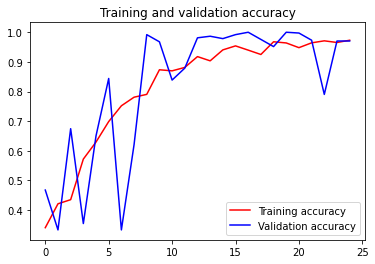

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Plot the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

# Model Prediction

You should be able to upload an image here and have it classified without crashing. This codeblock will only work in Google Colab, however. You can use your own images or use the ones available [here](https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-validation.zip)

**Important Note:** Due to some compatibility issues, the following code block will result in an error after you select the images(s) to upload if you are running this notebook as a `Colab` on the `Safari` browser. For all other browsers, continue with the next code block and ignore the next one after it.

_For Safari users: please comment out or skip the code block below, uncomment the next code block and run it._

In [ ]:
## CODE BLOCK FOR NON-SAFARI BROWSERS
## SAFARI USERS: PLEASE SKIP THIS BLOCK AND RUN THE NEXT ONE INSTEAD

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(fn)
  print(classes)

KeyboardInterrupt: ignored

`Safari` users will need to upload the images(s) manually in their workspace. Please follow the instructions, uncomment the code block below and run it.

Instructions on how to upload image(s) manually in a Colab:

1. Select the `folder` icon on the left `menu bar`.
2. Click on the `folder with an arrow pointing upwards` named `..`
3. Click on the `folder` named `tmp`.
4. Inside of the `tmp` folder, `create a new folder` called `images`. You'll see the `New folder` option by clicking the `3 vertical dots` menu button next to the `tmp` folder.
5. Inside of the new `images` folder, upload an image(s) of your choice. Drag and drop the images(s) on top of the `images` folder.
6. Uncomment and run the code block below. 

In [ ]:
# # CODE BLOCK FOR SAFARI USERS

# import os
# import numpy as np
# from keras.preprocessing import image

# images = os.listdir("/tmp/images")

# print(images)

# for i in images:
#     print()
#     # predicting images
#     path = '/tmp/images/' + i
#     img = image.load_img(path, target_size=(150, 150))
#     x = image.img_to_array(img)
#     x = np.expand_dims(x, axis=0)
    
#     images = np.vstack([x])
#     classes = model.predict(images, batch_size=10)
#     print(path)
#     print(classes)

## Wrap Up

That concludes this short exercise on the multi-class classifiers. You saw that with just a few changes, you were able to convert your binary classifiers to predict more classes. You used the same techniques for data and model preparation and were able to get relatively good results in just 25 epochs. For practice, you can search for other datasets (e.g. [here](https://archive.ics.uci.edu/ml/datasets.php) with more classes and revise the model to accomodate it. Try to experiment with different layers and data augmentation techniques to improve your metrics.